# Bike Sharing Demand

* 목표 : 주어진 데이터를 바탕으로 자전거 대여수요량을 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus = False)

sns.set(style='white')

# 1. 데이터 확인

* **datetime** :  시간단위의 timestamp
* **season** :  1 - 봄, 2 - 여름, 3 - 가을, 4 - 겨울
* **holiday** : 휴일인지 아닌지 구분
* **workingday** : 주말도 휴일도 아닌 날
* **weather**  
 - 1 : 맑거나 구름이 조금 있는 날
 - 2: 조금 안개끼고 구름있는 날
 - 3: 약간의 눈, 또는 약간의 비와 천둥과 구름, 약간의 비와 구름
 - 4: 비, 우박, 폭풍, 눈과 안개
* **temp** : 섭씨온도
* **atemp** : 체감 섭씨온도
* **humidity** : 상대습도
* **windspeed** : 풍속
* **casual** : 비회원의 대여수
* **registered** : 회원의 대여수
* **count** : 총 대여수 = casual + registered

In [2]:
# train 데이터셋 확인
train = pd.read_csv('input/train.csv')
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


train 셋은 10,886개의 관측치와 12개의 컬럼으로 구성
 - casual, registered, count는 예측해야할 target. 나머지 9개는 살펴봐야할 feature들

In [3]:
# test 데이터셋 확인
test = pd.read_csv('input/test.csv')
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


test 셋은 6,493개의 관측치와 9개의 컬럼으로 구성

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


* train과 test셋은 모두 null 값이 없는 것으로 보이며 object형인 datetime 빼고는 모두 숫자형 데이터
* 하지만 데이터가 없는걸 null 대신 다른 임의의 값으로 채우는 경우도 있기 때문에 EDA할 때 잘 살펴볼 것
* datetime은 EDA 및 전처리에 용이하게 datetime 형식으로 데이터를 변경

In [6]:
# object형인 datetime 컬럼을 datetime형식으로 변경
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [7]:
# EDA에 앞서 datetime을  년, 월, 일, 요일, 시간, 분, 초 로 나누기
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['weekday'] = train['datetime'].dt.weekday  # 0 : 월요일 ~ 6 : 일요일
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

# train 의 'datetime' 컬럼 삭제
train.drop(['datetime'], axis=1, inplace=True)

# train 다시 조회
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour,minute,second
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4,0,0


In [8]:
# test 셋에도 동일하게 적용
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['weekday'] = test['datetime'].dt.weekday
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

# test 의 'datetime' 컬럼 삭제
test.drop(['datetime'], axis=1, inplace=True)

# train 다시 조회
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,weekday,hour,minute,second
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4,0,0


# 2. EDA

## (1) 시간관련 Feature : season, holilday, workingday 및 datetime에서 파생된 feature

### train과 test 셋 비교

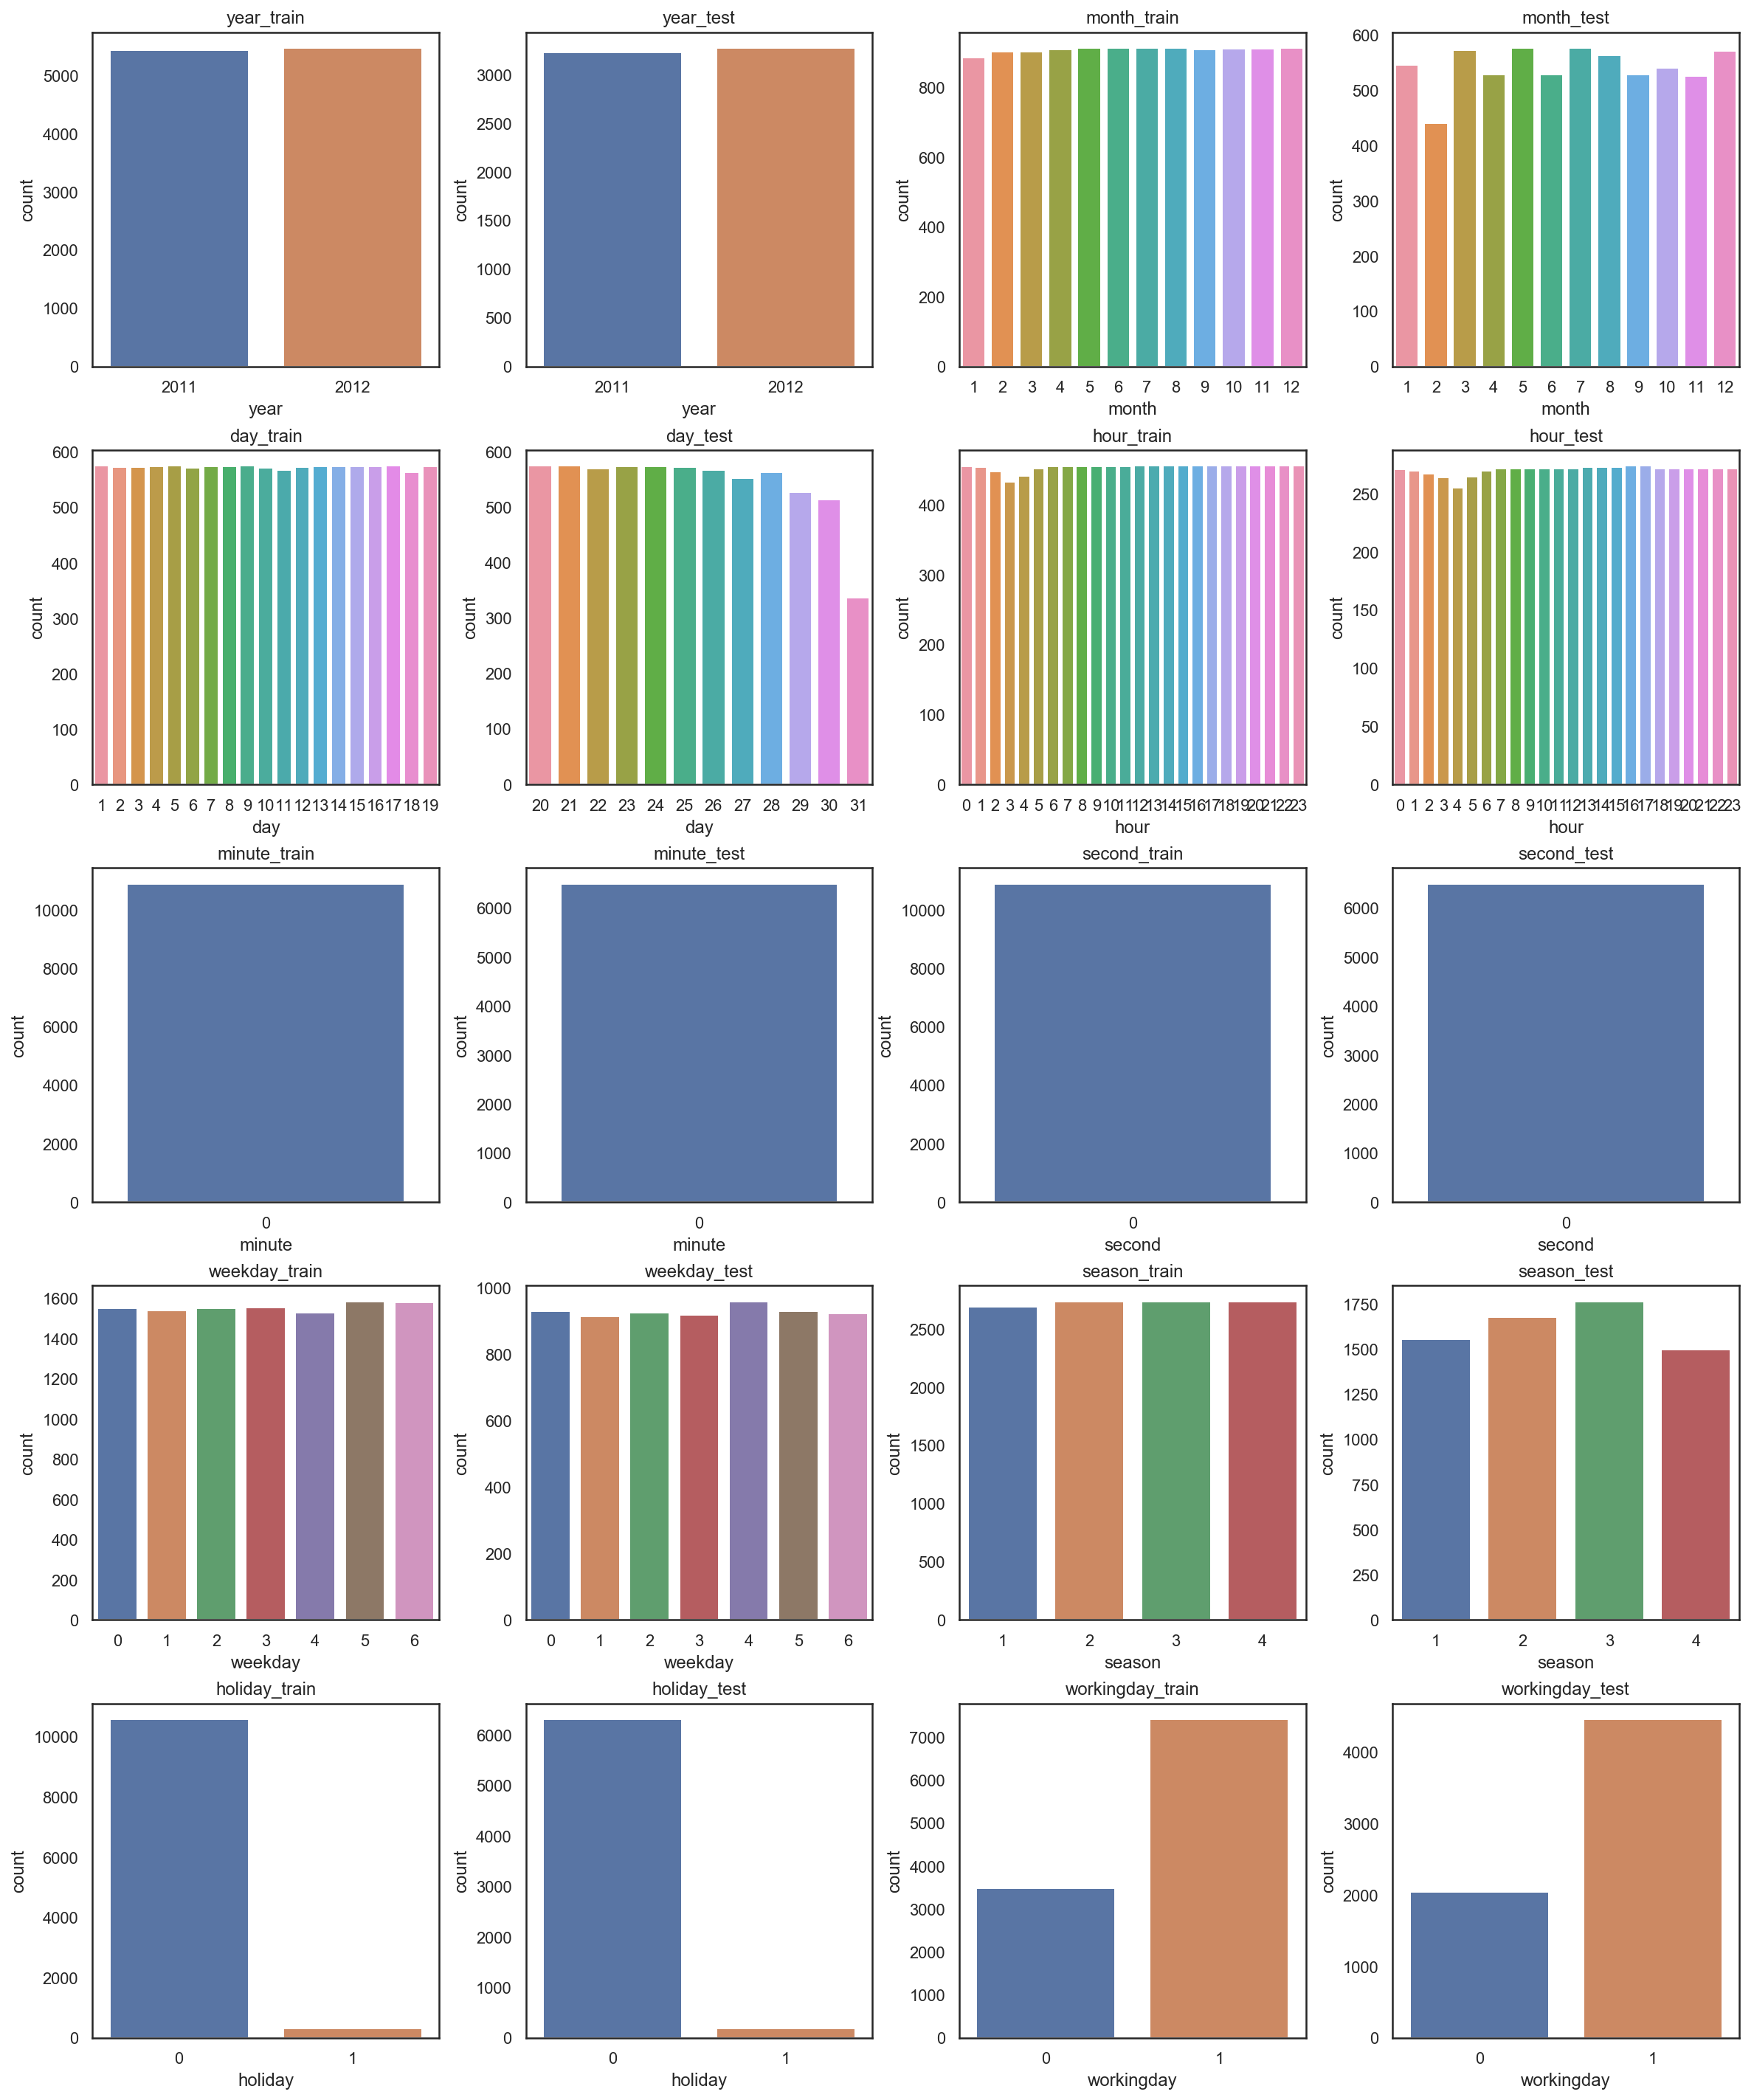

In [9]:
f, ax = plt.subplots(5, 4, figsize=(20, 25))

sns.countplot(data=train, x='year', ax = ax[0,0]).set_title('year_train')
sns.countplot(data=test, x='year', ax = ax[0,1]).set_title('year_test')
sns.countplot(data=train, x='month', ax = ax[0,2]).set_title('month_train')
sns.countplot(data=test, x='month', ax = ax[0,3]).set_title('month_test')
sns.countplot(data=train, x='day', ax = ax[1,0]).set_title('day_train')
sns.countplot(data=test, x='day', ax = ax[1,1]).set_title('day_test')
sns.countplot(data=train, x='hour', ax = ax[1,2]).set_title('hour_train')
sns.countplot(data=test, x='hour', ax = ax[1,3]).set_title('hour_test')
sns.countplot(data=train, x='minute', ax = ax[2,0]).set_title('minute_train')
sns.countplot(data=test, x='minute', ax = ax[2,1]).set_title('minute_test')
sns.countplot(data=train, x='second', ax = ax[2,2]).set_title('second_train')
sns.countplot(data=test, x='second', ax = ax[2,3]).set_title('second_test')
sns.countplot(data=train, x='weekday', ax = ax[3,0]).set_title('weekday_train')
sns.countplot(data=test, x='weekday', ax = ax[3,1]).set_title('weekday_test')
sns.countplot(data=train, x='season', ax = ax[3,2]).set_title('season_train')
sns.countplot(data=test, x='season', ax = ax[3,3]).set_title('season_test')
sns.countplot(data=train, x='holiday', ax = ax[4,0]).set_title('holiday_train')
sns.countplot(data=test, x='holiday', ax = ax[4,1]).set_title('holiday_test')
sns.countplot(data=train, x='workingday', ax = ax[4,2]).set_title('workingday_train')
sns.countplot(data=test, x='workingday', ax = ax[4,3]).set_title('workingday_test')

plt.subplots_adjust(hspace=0.25, wspace = 0.25)

* day : train에는 1~20일, test에는 21일 이후의 데이터만 있음
   --> (1) day나 season의 train, test셋의 분포가 차이가 나는 것도 이것때문 인듯
   --> (2) 일자 변경에 따른 뚜렷한 트렌드가 있지 않는 한 굳이 고려할 필요 없는 feature로 보임
   
* minute/second : 0 밖에 없으므로 데이터 버림

In [10]:
# train과 test 데이터에서 minute, second 삭제
train.drop(['minute','second'], axis=1, inplace=True)
test.drop(['minute','second'], axis=1, inplace=True)

In [11]:
train[['season', 'month']].groupby(['season','month'])['month'].count()

season  month
1       1        884
        2        901
        3        901
2       4        909
        5        912
        6        912
3       7        912
        8        912
        9        909
4       10       911
        11       911
        12       912
Name: month, dtype: int64

* 봄(1), 여름(2), 가을(3), 겨울(4)이 흔히 생각하는 월이 매치가 되지 않음
  --> 월에 맞게 바꿔서 본 season과 원래 season을 비교해보면 어떨까

In [12]:
# 계절과 월이 매치되도록 조정한 season_adjust 생성
train.loc[ (train['month'] <=2)|(train['month']==12) ,'season_adjust'] = 4
train.loc[ (train['month'] >2) & (train['month']<=5) ,'season_adjust'] = 1
train.loc[ (train['month'] >5) & (train['month']<=8) ,'season_adjust'] = 2
train.loc[ (train['month'] >8) & (train['month']<=11 ) ,'season_adjust'] = 3

test.loc[ (test['month'] <=2)|(test['month']==12) ,'season_adjust'] = 4
test.loc[ (test['month'] >2) & (test['month']<=5) ,'season_adjust'] = 1
test.loc[ (test['month'] >5) & (test['month']<=8) ,'season_adjust'] = 2
test.loc[ (test['month'] >8) & (test['month']<=11 ) ,'season_adjust'] = 3

### 날짜관련 feature들의 count

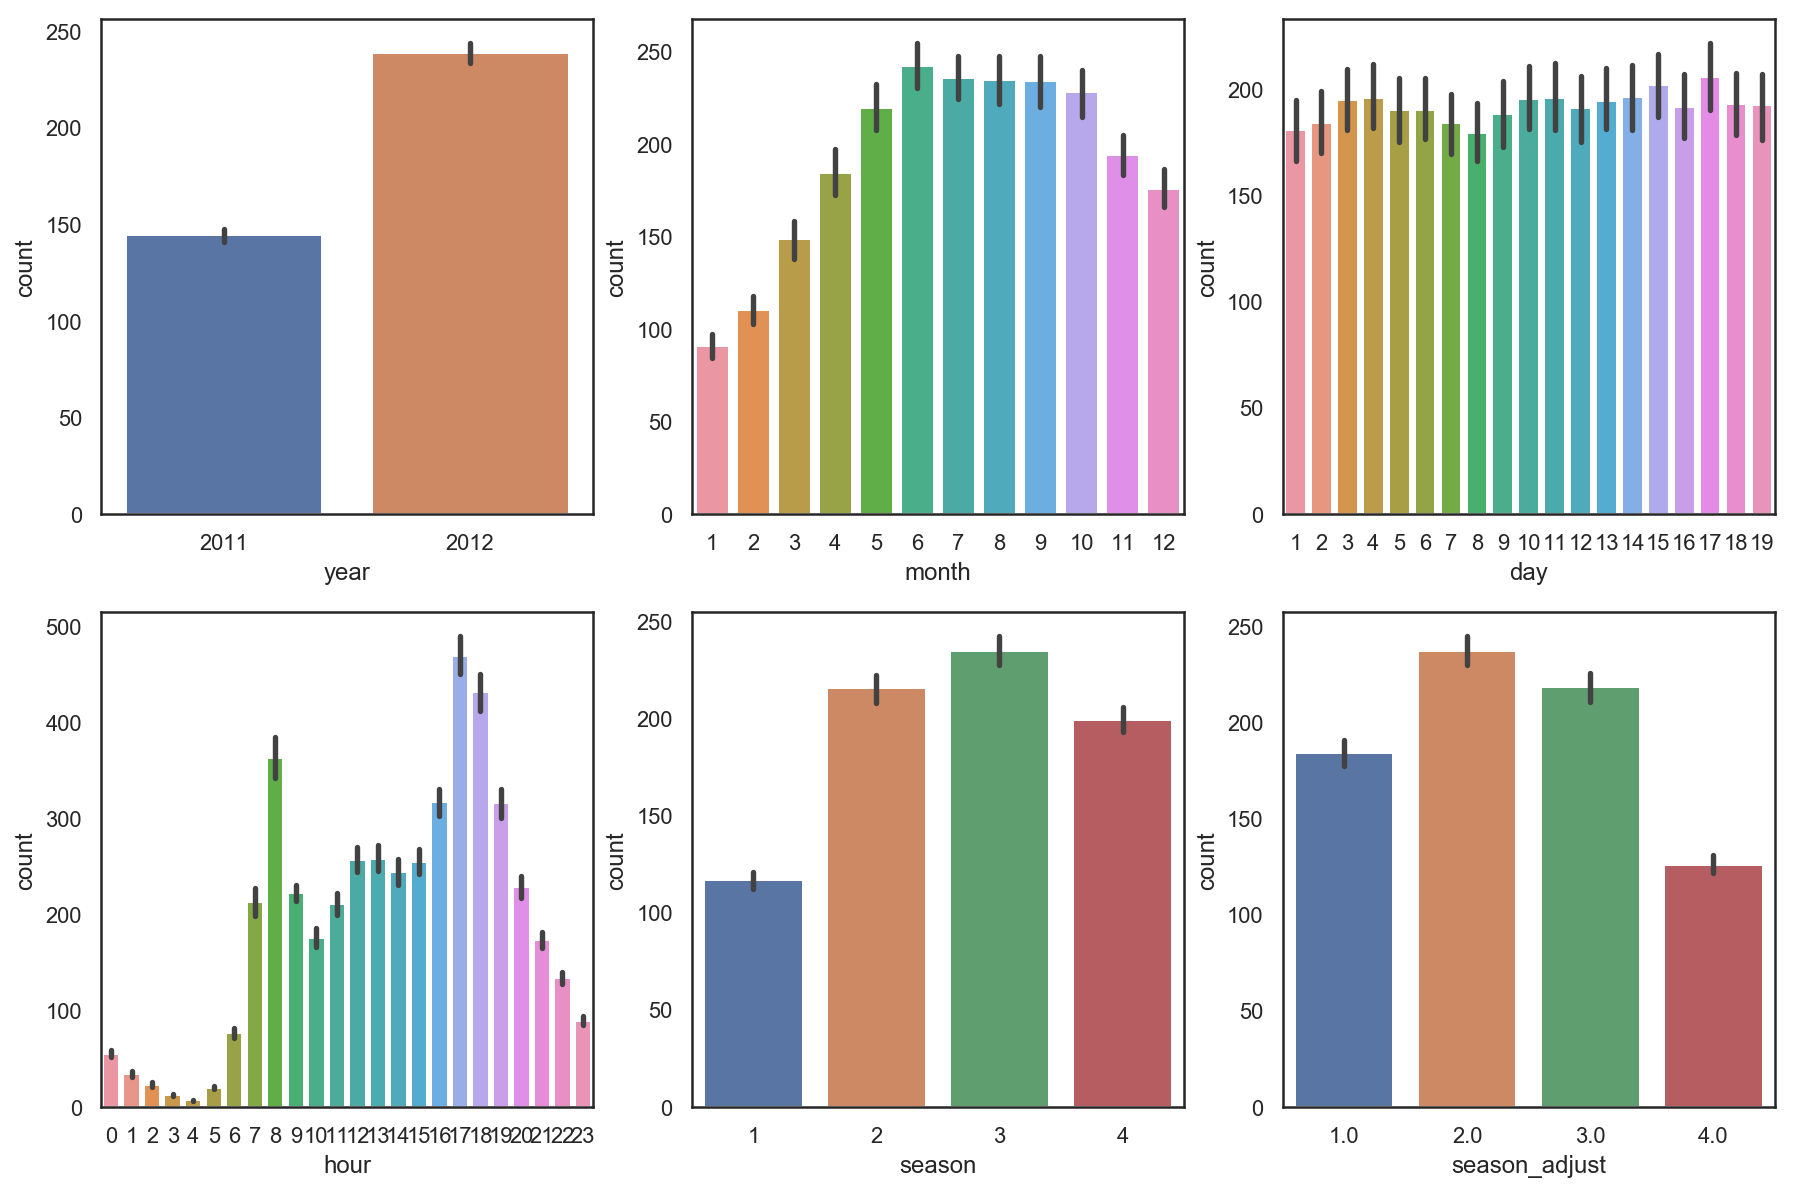

In [13]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))

sns.barplot(data=train, x='year', y='count', ax=ax[0,0])
sns.barplot(data=train, x='month', y='count', ax=ax[0,1])
sns.barplot(data=train, x='day', y='count', ax=ax[0,2])
sns.barplot(data=train, x='hour', y='count', ax=ax[1,0])
sns.barplot(data=train, x='season', y='count', ax=ax[1,1])
sns.barplot(data=train, x='season_adjust', y='count', ax=ax[1,2])

plt.show()

* 2011년보다 2012년에 대여량이 많다.
* 5월부터 10월까지 대여량이 많다.
* 일자별로는 대여량의 차이는 크게 차이가 없어 보임 --> 모델링에서 고려할 필요 없어 보임
* 시간대별로 보면 8시, 17, 18시에 대여량이 가장 많음, 밤시간대 21시~6시에는 대여량이 낮음
* season로 봤을 때는 봄인 1의 대여량이 가장 낮았는데, season_adjust로 조정 후에는 겨울인 4의 대여량이 가장 낮음 
   => season_adjust로 나타나는 패턴이 일반적인 상식과 비슷한 패턴이나 모델에 넣었을 때 어떤게 더 잘 나올지는 봐야함

### 연도+월별 count

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

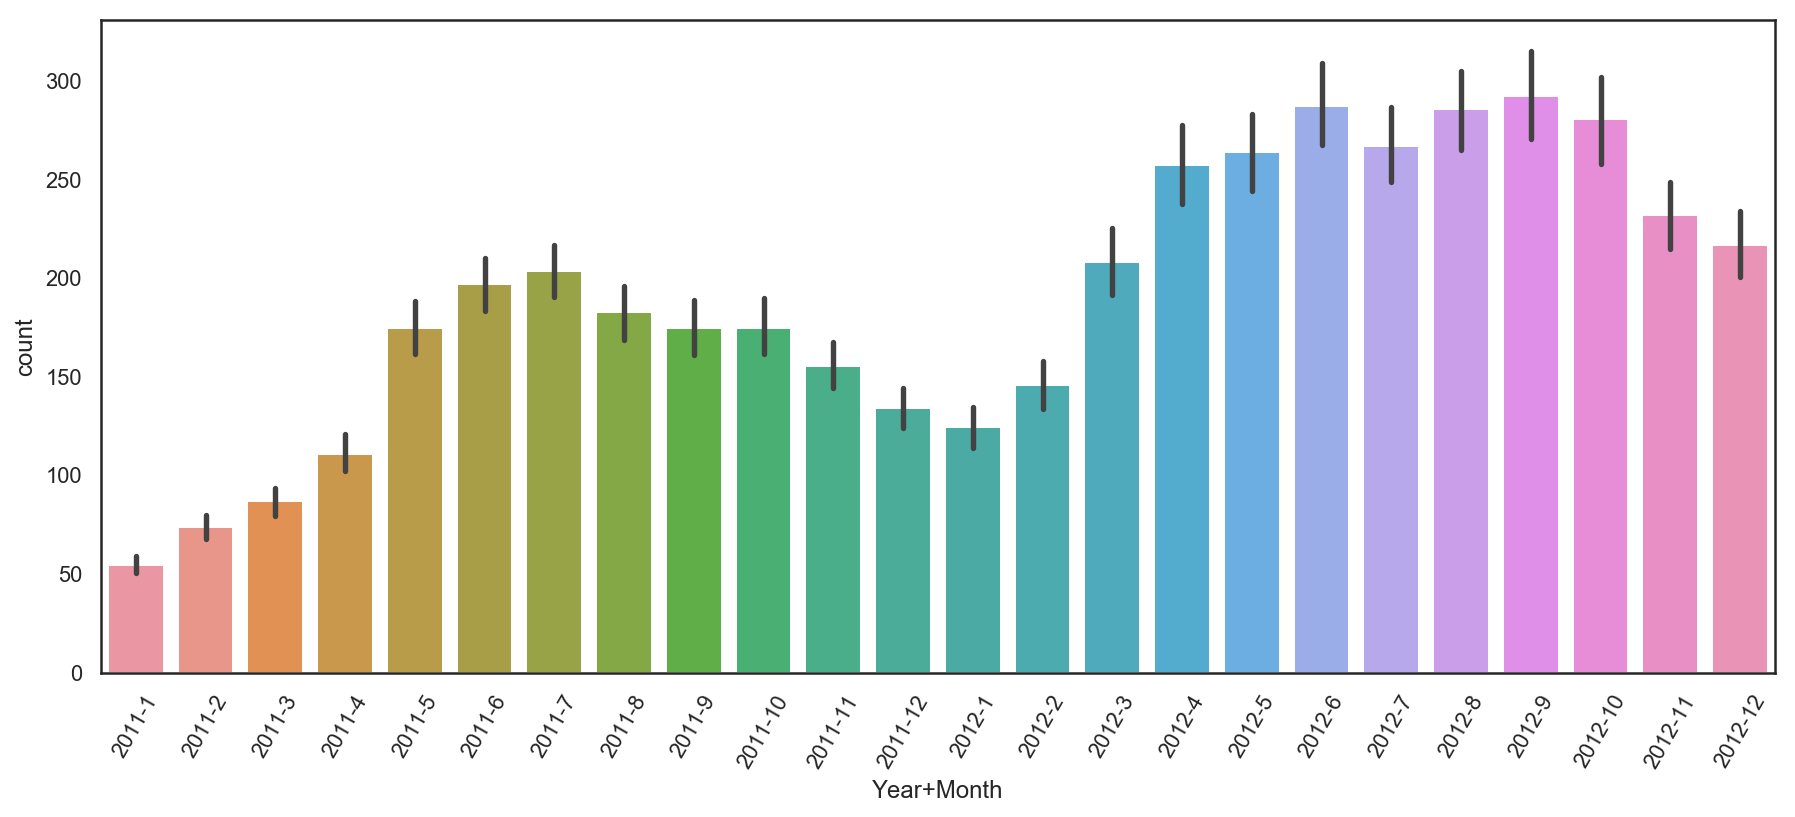

In [14]:
train['Year+Month'] = train['year'].astype(str)+'-'+train['month'].astype(str)
test['Year+Month'] = test['year'].astype(str)+'-'+test['month'].astype(str)
plt.figure(figsize=(15, 6))
sns.barplot(data=train, x= 'Year+Month', y='count')
plt.xticks(rotation=60)

* 2011년보다 2012년의 대여량이 확실히 높고, 연도별로 봐도 5~10월의 대여량이 높음
* 대여량이 낮은 겨울이라도 2012년 12월의 대여량은 2011년 고점보다도 높음

--> Year와 Month를 각각 모델에 넣을지,  동시에 고려한 year-month를 모델에 넣는게 좋은 결과가 나올지?

### weekday에 따른 count(casual+registered)

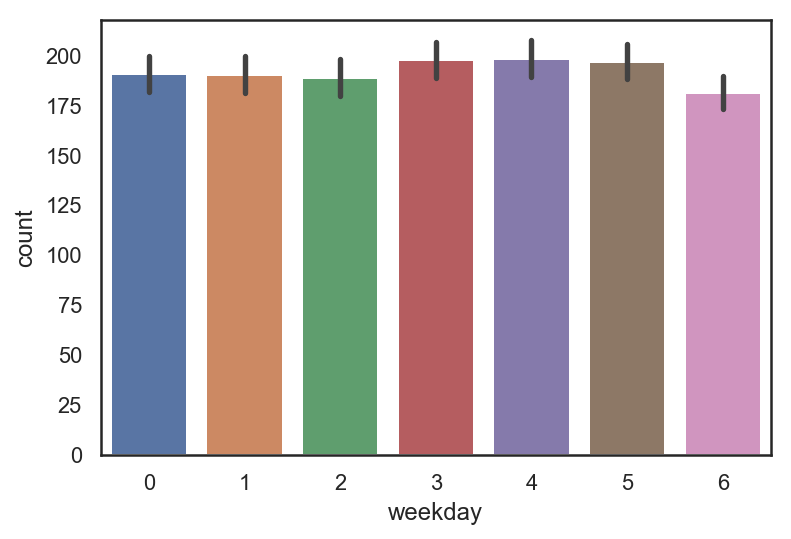

In [15]:
sns.barplot(data=train, x='weekday', y= 'count')
plt.show()

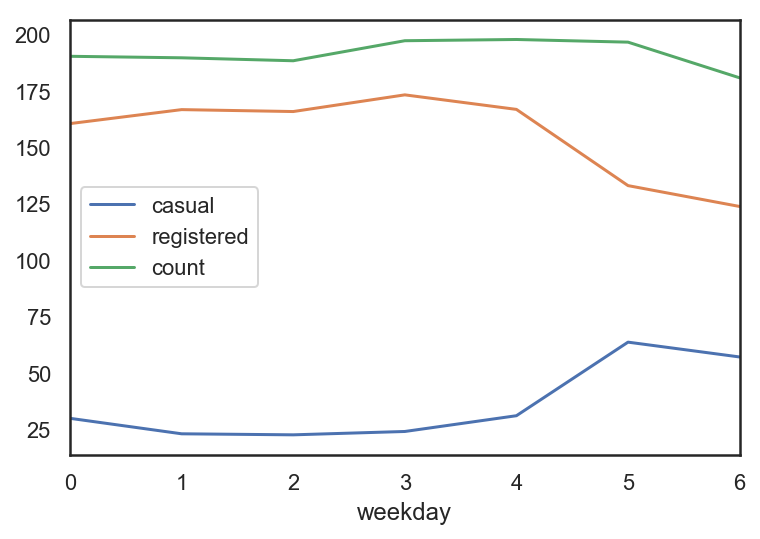

In [16]:
train.groupby(['weekday'])[['casual','registered','count']].mean().plot()
plt.show()

* 요일별로 큰 차이가 나는 것은 아니지만 일요일(6)의 대여량이 가장 낮고,  목~토(3~5)의 대여량이 높으며, 월~수(0~2)의 대여량은 중간쯤
* 이거를 casual, registered로 쪼개서 보면, casual은 주말인 5~6에 늘어나고, registered는 평일에 높음

### hour에 따른 count(casual+registered)

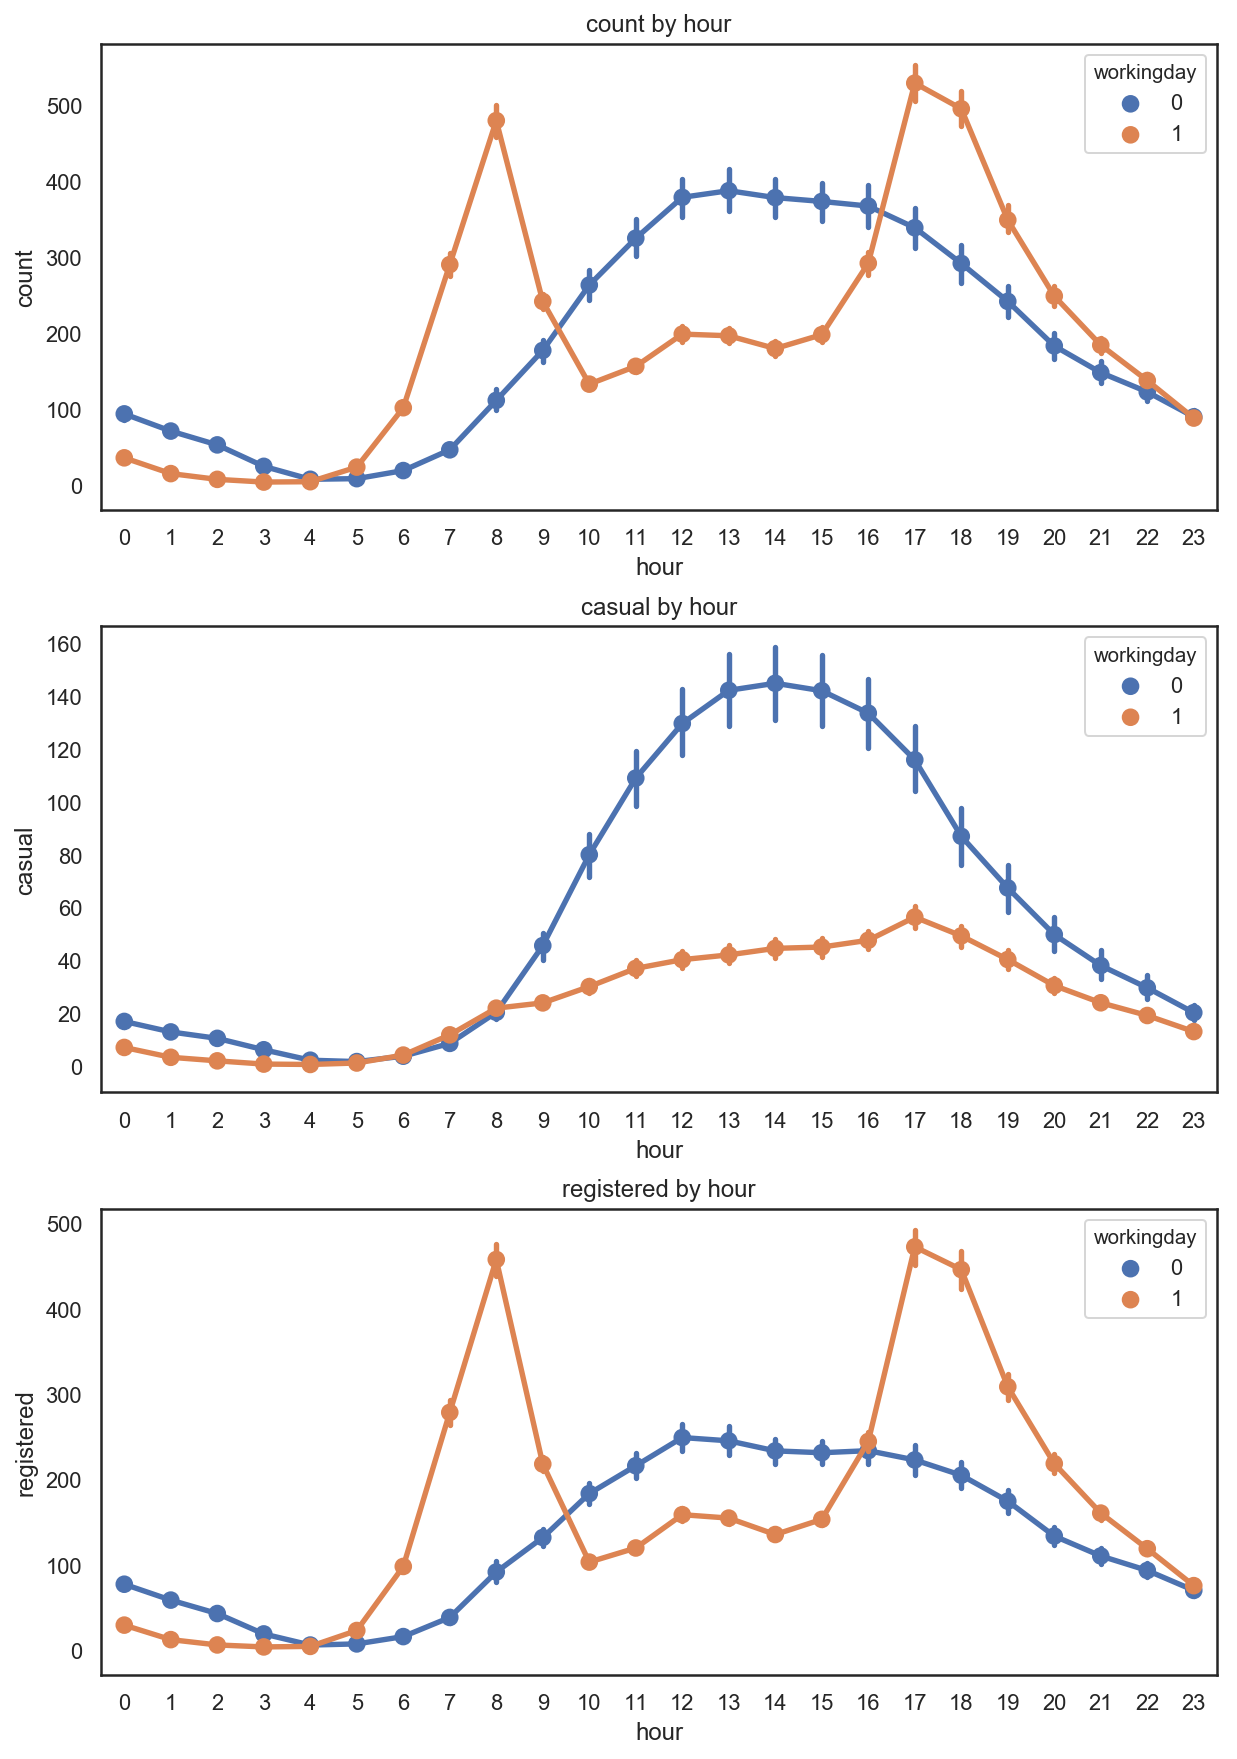

In [17]:
f, ax = plt.subplots(3, 1, figsize=(10, 15))
column = ['count','casual','registered']
i = 0

for c in column:
    sns.pointplot(data=train, x='hour', hue='workingday', y=c, ax=ax[i]).set_title(c+' by hour')
    i += 1

plt.subplots_adjust(hspace=0.25)

### holiday와 workingday에 따른 count(casual+registered)

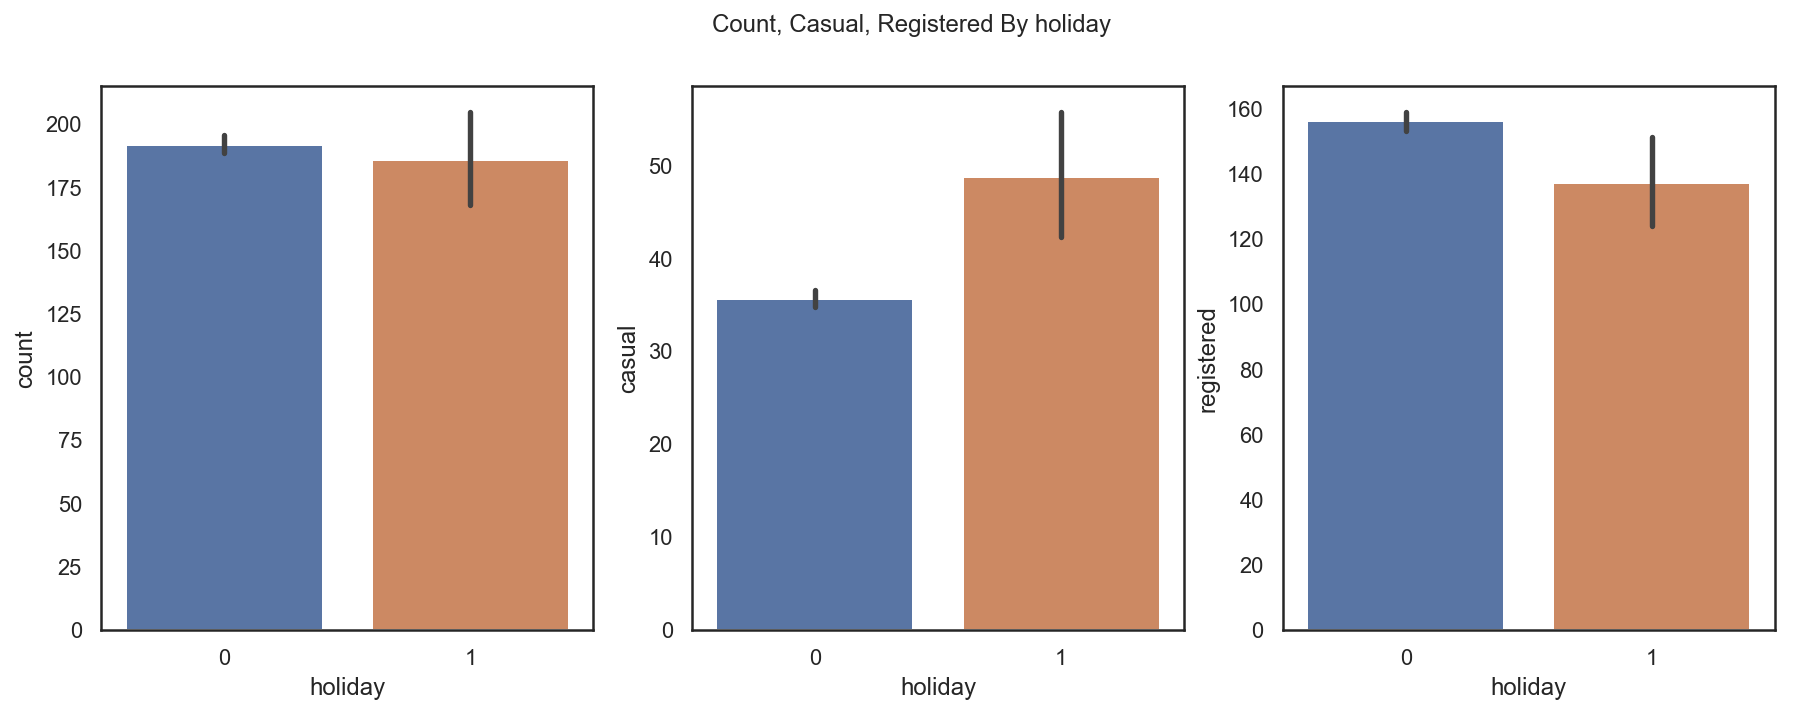

In [18]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=train, x='holiday', y='count', ax=ax[0])
sns.barplot(data=train, x='holiday', y='casual', ax=ax[1])
sns.barplot(data=train, x='holiday', y='registered', ax=ax[2])
plt.suptitle('Count, Casual, Registered By holiday')
plt.show()

* holiday일 때(holiday==1), 대여량이 조금 더 낮음
  - casual의 경우, 반대로 holiday일 때 대여량이 높음
  - registered의 경우, holiday일때 대여량이 낮음 

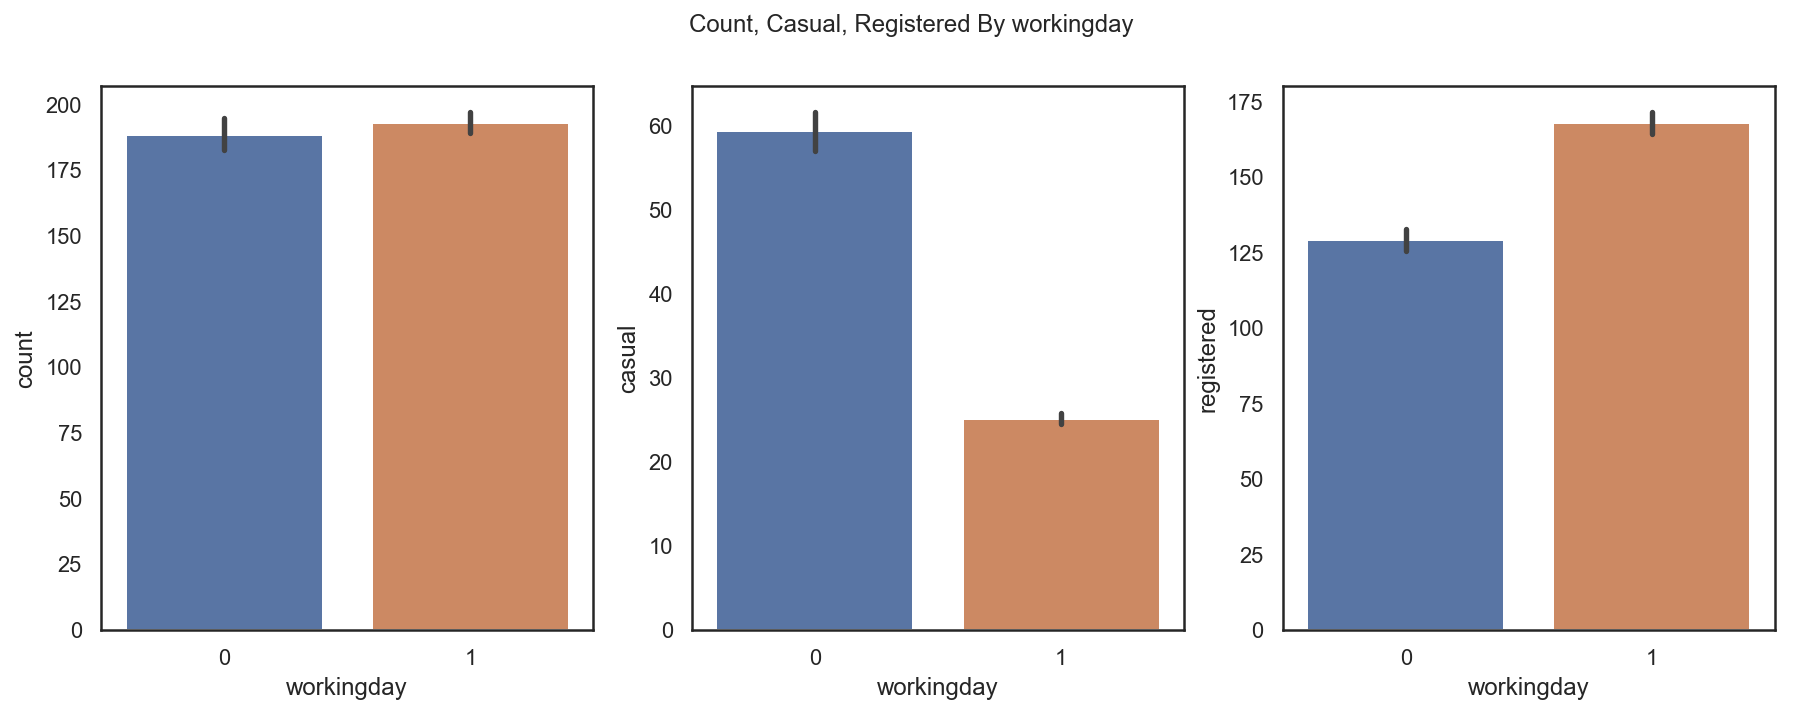

In [19]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=train, x='workingday', y='count', ax=ax[0])
sns.barplot(data=train, x='workingday', y='casual', ax=ax[1])
sns.barplot(data=train, x='workingday', y='registered', ax=ax[2])

plt.suptitle('Count, Casual, Registered By workingday')
plt.show()

* workingday일 때(workingday==1), 대여량이 조금 더 높음
  - casual의 경우, 반대로 workingday일 때 대여량이 더 낮음
  - registered의 경우, workingday일 때 대여량이 더 높음

## (2) Weather와 Count(Casual+Registered)

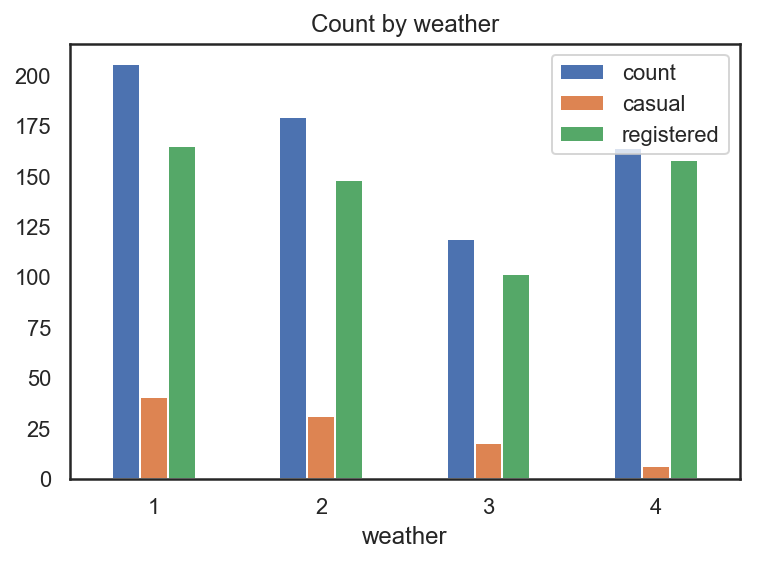

In [20]:
train[['weather','count','casual','registered']].groupby(['weather'])['count','casual','registered']\
                                                .mean().plot(kind='bar').set_title('Count by weather')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

* 날씨가 안좋아지면서 (1 -> 2 -> 3) 대여량은 casual이든 registered이든 다 줄어드는데, 제일 궂은 날씨인 4에서는 registered의 대여량이 다시 늘어남

## (3) 그외 float형의 feature들 (temp, atemp, humidity, windspeed)

In [21]:
train[['temp','atemp','humidity', 'windspeed']].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


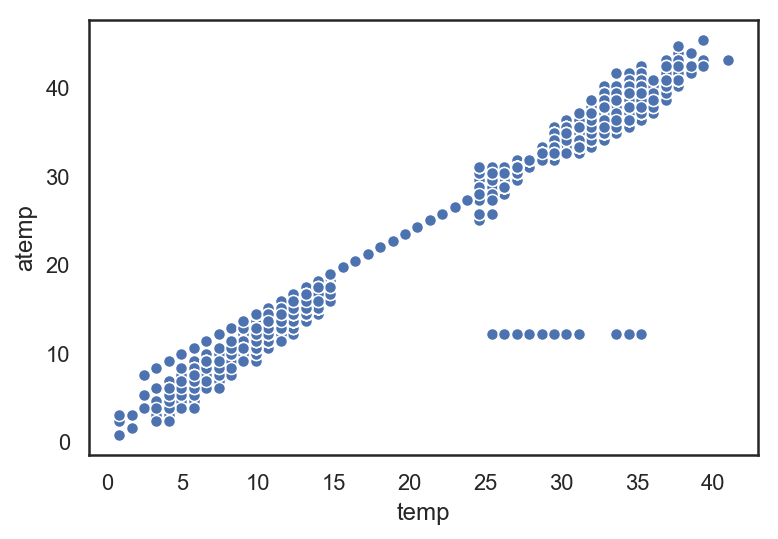

In [22]:
# temp와 atemp의 선형관계 보기
sns.scatterplot(data=train, x='temp', y='atemp')
plt.show()

* temp(온도)와 atemp(체감온도)는 거의 선형관계를 나타내고, temp가 25~35도인데, atemp가 15도 이하의 잘못된 값인 듯한 관측치가 보여 atemp는 이번에는 버림

In [23]:
train.drop(['atemp'], axis=1, inplace=True)
test.drop(['atemp'], axis=1, inplace=True)

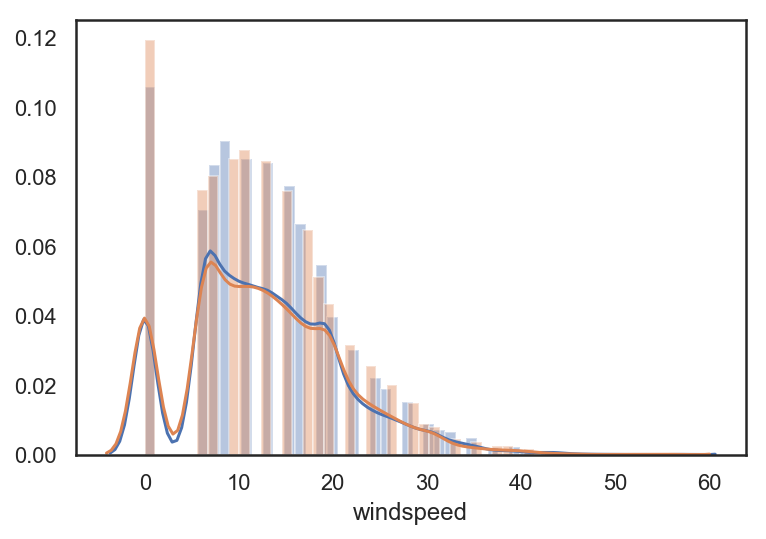

In [24]:
sns.distplot(train['windspeed'])
sns.distplot(test['windspeed'])
plt.show()

windspeed가 0이라는거는 현실적으로 불가능해보이는데, 관측치가 많은 것으로 봐서 사실상의 NaN 값으로 보임

--> 0을 다른 값으로 대체해볼 필요

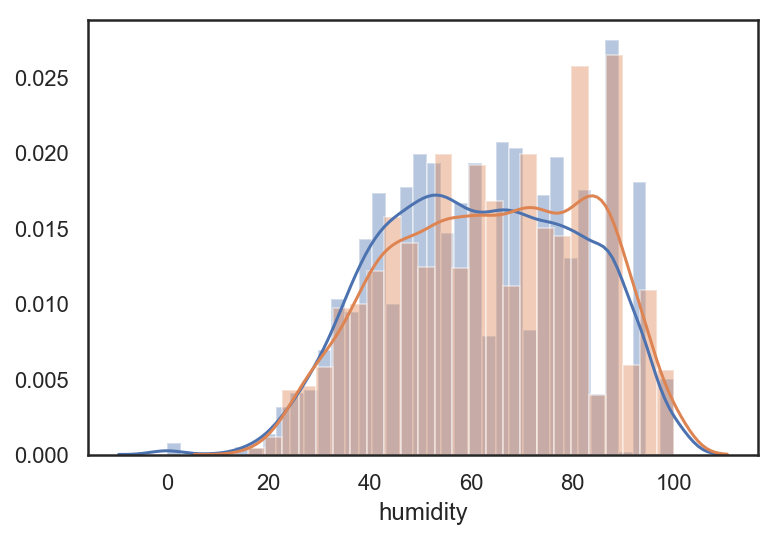

In [25]:
sns.distplot(train['humidity'])
sns.distplot(test['humidity'])
plt.show()

humidity가 0인 것도 사실 불가능해보이기는 하지만, 관측값이 그다지 없음

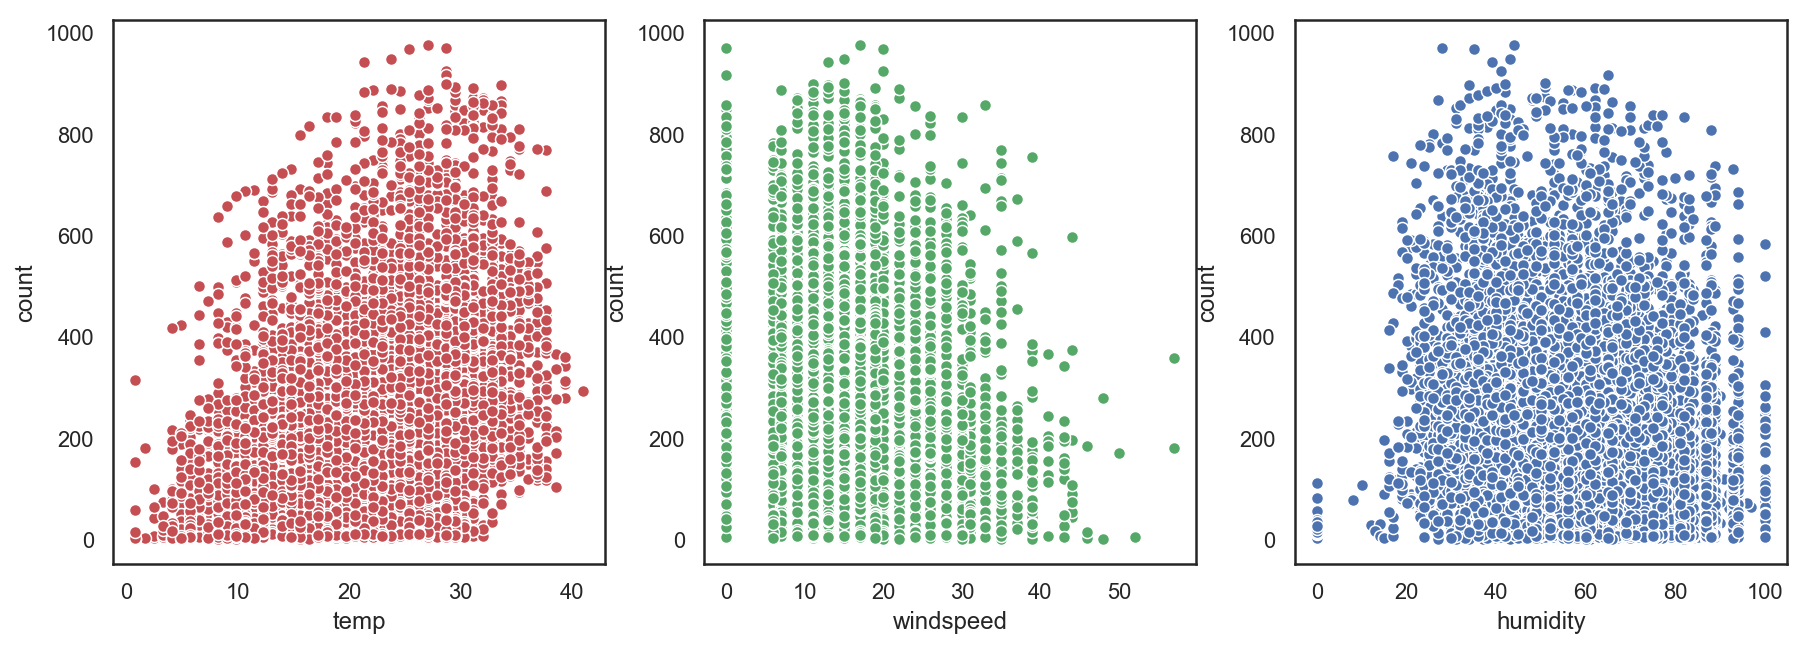

In [26]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(data=train, x='temp', y='count', ax=ax[0], color='r')
sns.scatterplot(data=train, x='windspeed', y='count', ax=ax[1], color='g')
sns.scatterplot(data=train, x='humidity', y='count', ax=ax[2], color='b')

plt.show()

* scatterplot 으로 그려보았을 때, 이 세개의 feature가 count와 크게 상관있는지는 모르겠음

## (4) Count, Casual, Registered의 분포 확인

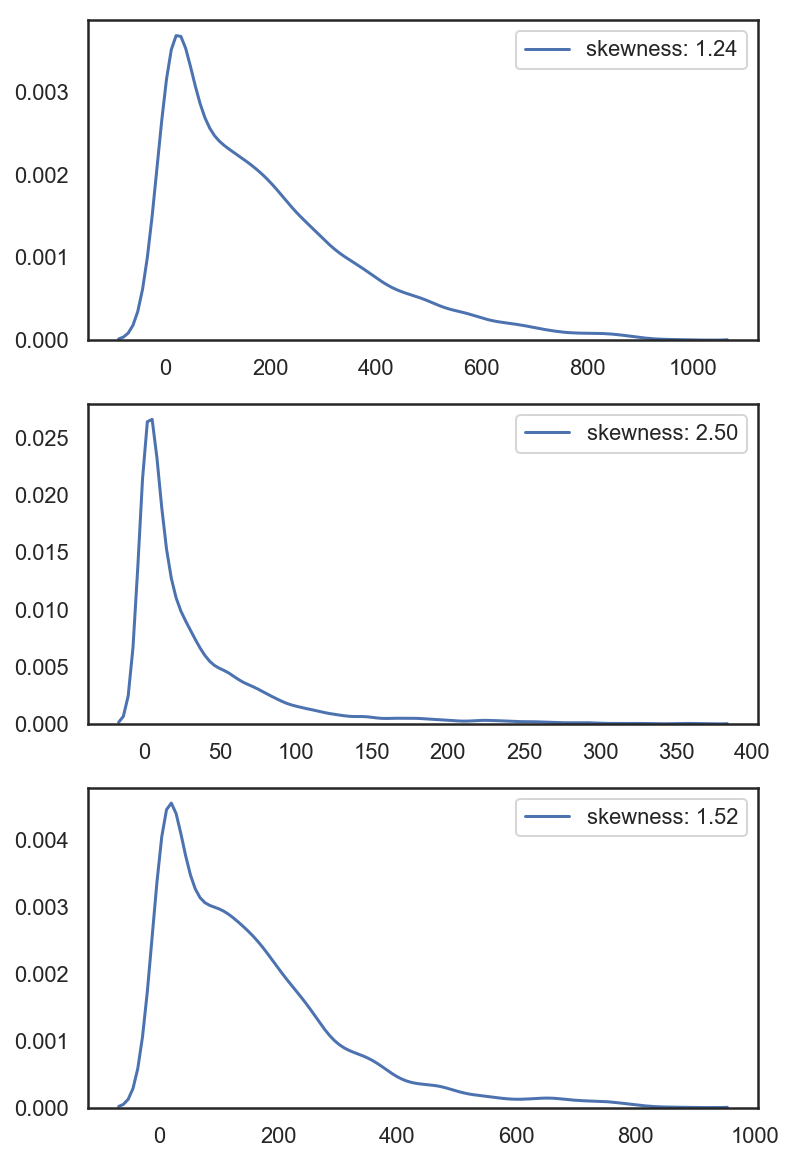

In [43]:
f, ax  = plt.subplots(3, 1, figsize=(6, 10))
sns.kdeplot(train['count'], label='skewness: {:.2f}'.format(train['count'].skew()), ax=ax[0])
sns.kdeplot(train['casual'], label='skewness: {:.2f}'.format(train['casual'].skew()), ax=ax[1])
sns.kdeplot(train['registered'], label='skewness: {:.2f}'.format(train['registered'].skew()), ax=ax[2])
plt.legend()
plt.show()

* 세 가지 모두 치우친 분포를 가지고 있음
 - 로그를 취해서 치우친 정도를 줄이기

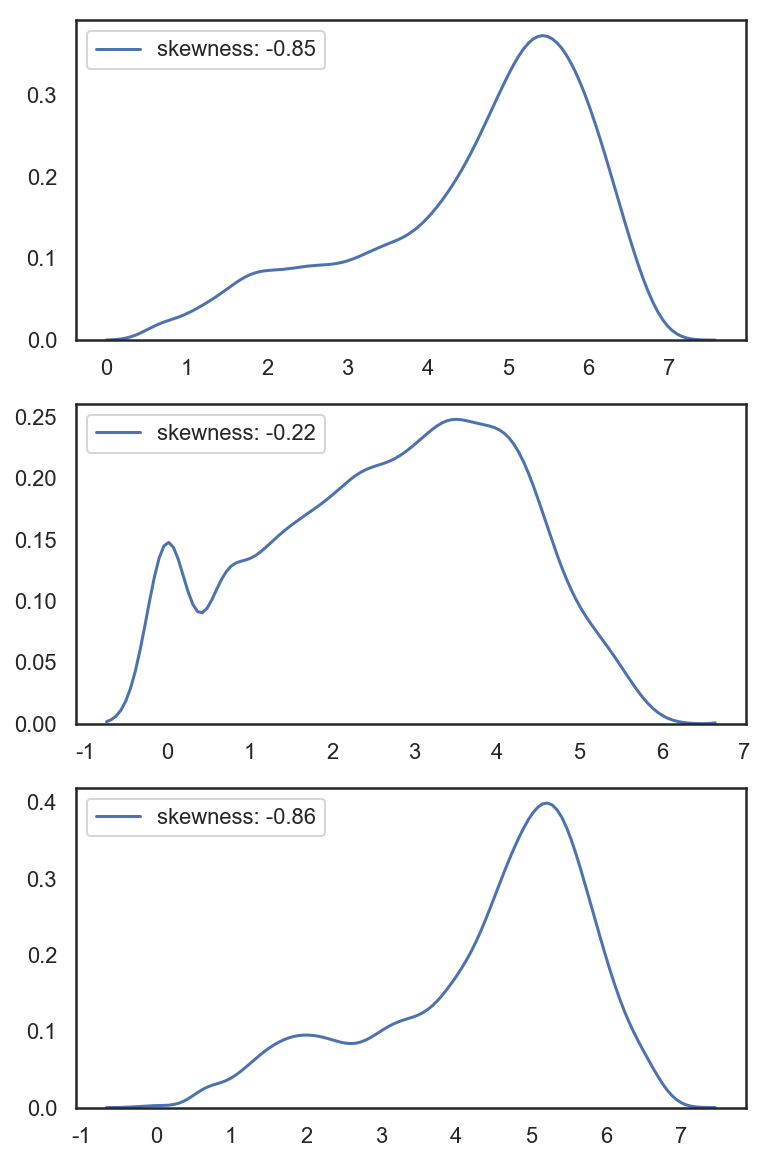

In [46]:
f, ax  = plt.subplots(3, 1, figsize=(6, 10))
sns.kdeplot(np.log(train['count']+1), label='skewness: {:.2f}'.format(np.log(train['count']+1).skew()), ax=ax[0])
sns.kdeplot(np.log(train['casual']+1), label='skewness: {:.2f}'.format(np.log(train['casual']+1).skew()), ax=ax[1])
sns.kdeplot(np.log(train['registered']+1), label='skewness: {:.2f}'.format(np.log(train['registered']+1).skew()), ax=ax[2])
plt.legend()
plt.show()

### 정리 

* 같은 feature라도 casual과 registered에서 나타나는 양상이 다름
  - 합친 값인 count로 봤을 때는 registered의 양이 casual보다 상당히 많기 때문에, registered의 패턴이 나타남
* 시간관련 Feature
  - year : 2011년보다 2012년의 대여량이 전반적으로 많음
  - month / season : 추운 겨울 시즌의 대여량이 전반적으로 낮음
  - Year+Month : 겨울이 상대적으로 적다고 하더라도 2011년 12월은 평균 최고 평균월(2010년 7월)보다도 높음 
     * year, month를 각각 넣거나, Year+Month 하나를 모델에 넣는게 더 나을지...
  - hour 
     * (registered) 출퇴근시간(8시, 17~18시) 대여량이 많음(단, workingday==0 이면 10~15시의 대여량이 많음) 
     * (casual) workingday에 관계없이 밝은 시간대 대여량이 많음
  - weekday 
     * (registered) 주말 이용량이 적음 
     * (casual) 주말 이용량이 더 많음
* weather
  - 날씨가 안좋아질수록(1 -> 2 -> 3)로 갈수록 대여량이 감소하나, registered에서 제일 안좋은 날씨인 4에서 대여량이 다시 증가
* 그외 float형의 feature들 (temp, humidity, windspeed)
  - 뚜렷한 특징은 발견하지는 못했으며, windspeed의 경우 결측치(0)을 채워서 살펴볼 필요가 있음

# 3. Feature Engineering

## (1) 카테고리형 변수